# Data Preprocessing

This notebook handles data cleaning, feature engineering, and preparation for modeling

## Objectives:
- Clean and normalize text data
- Handle missing values and duplicates
- Create additional features
- Prepare data for modeling
- Save preprocessed data

## Setup and Imports

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

from tqdm.auto import tqdm
tqdm.pandas()

np.random.seed(7)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load Raw Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/quora_duplicate_questions/data/'

In [3]:
train_df = pd.read_csv(os.path.join(PATH, 'raw/train.csv.zip'),
                       index_col=0,
                       compression='zip')

print(f"Dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print("\nFirst few rows:")
train_df.head()

Dataset shape: (323432, 5)

Columns: ['qid1', 'qid2', 'question1', 'question2', 'is_duplicate']

First few rows:


,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


## Data Quality Assessment

In [4]:
# Check for missing values
print("=== Missing Values ===")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0])

# Check for duplicate rows
print(f"\n=== Duplicate Rows ===")
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


=== Missing Values ===
question1    1
question2    2
dtype: int64

=== Duplicate Rows ===
Number of duplicate rows: 0


## Handle Missing Values

In [5]:
missing_before = train_df.isnull().sum().sum()
print(f"Missing values before handling: {missing_before}")

# Remove rows where one of questions is empty
train_df = train_df.dropna(subset=['question1', 'question2'])

missing_after = train_df.isnull().sum().sum()
print(f"Missing values after handling: {missing_after}")
print(f"Final dataset shape: {train_df.shape}")

Missing values before handling: 3
Missing values after handling: 0
Final dataset shape: (323429, 5)


## Text Preprocessing

In [6]:
def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


def preprocess_pipeline(text, remove_stopwords=True, stem=True):
    """Process text by cleaning and tokenizing"""
    cleaned_text = clean_text(text)

    if not cleaned_text:
        return ""
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    tokens = word_tokenize(cleaned_text)

    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    if stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [7]:
train_df['question1_clean'] = (train_df['question1']
                               .progress_apply(preprocess_pipeline))
train_df['question2_clean'] = (train_df['question2']
                               .progress_apply(preprocess_pipeline))
print("Text preprocessing completed!")

  0%|          | 0/323429 [00:00<?, ?it/s]

  0%|          | 0/323429 [00:00<?, ?it/s]

Text preprocessing completed!


In [ ]:
# Show examples
print("Preprocessing examples:")
for i in np.random.choice(train_df.index, size=3, replace=False):
    print(f"\nExample {i}:")
    print(f"Original Q1: {train_df.loc[i, 'question1']}")
    print(f"Cleaned Q1:  {train_df.loc[i, 'question1_clean']}")
    print(f"Original Q2: {train_df.loc[i, 'question2']}")
    print(f"Cleaned Q2:  {train_df.loc[i, 'question2_clean']}")

Preprocessing examples:

Example 106221:
Original Q1: Which hindi movies, released in 2012 are a must watch?
Cleaned Q1:  hindi movi releas 2012 must watch
Original Q2: Which are some must watch Bengali movies released after 2000?
Cleaned Q2:  must watch bengali movi releas 2000

Example 190410:
Original Q1: What types of dog breeds love cuddling the most?
Cleaned Q1:  type dog breed love cuddl
Original Q2: What are the benefits of breezer?
Cleaned Q2:  benefit breezer

Example 32335:
Original Q1: Why does Quora limit my question details to 300 characters?
Cleaned Q1:  quora limit question detail 300 charact
Original Q2: Why does Quora have a character limit in Question Details?
Cleaned Q2:  quora charact limit question detail


## Feature Engineering

In [8]:
def calculate_text_features(df):
    """
    Create various text-based features.
    Args:
        df: DataFrame containing text data.
    Returns:
        DataFrame with additional length features.
    """
    df = df.copy()
    # Length features
    df['q1_len'] = df['question1_clean'].str.len()
    df['q2_len'] = df['question2_clean'].str.len()
    df['len_diff'] = abs(df['q1_len'] - df['q2_len'])
    df['len_ratio'] = (df[['q1_len', 'q2_len']].min(axis=1)
                       / (df[['q1_len', 'q2_len']].max(axis=1) + 1e-5))

    # Word count features
    df['q1_words'] = df['question1_clean'].str.split().str.len()
    df['q2_words'] = df['question2_clean'].str.split().str.len()
    df['words_diff'] = abs(df['q1_words'] - df['q2_words'])
    df['words_ratio'] = (
        df[['q1_words', 'q2_words']].min(axis=1)
        / (df[['q1_words', 'q2_words']].max(axis=1) + 1e-5)
    )

    # Statistical features
    df['q1_question_marks'] = df['question1'].apply(
        lambda x: str(x).count('?'))
    df['q2_question_marks'] = df['question2'].apply(
        lambda x: str(x).count('?'))
    df['question_marks_diff'] = abs(df['q1_question_marks']
                                    - df['q2_question_marks'])

    df['q1_dots'] = df['question1'].apply(
        lambda x: str(x).count('.'))
    df['q2_dots'] = df['question2'].apply(
        lambda x: str(x).count('.'))
    df['dots_diff'] = abs(df['q1_dots'] - df['q2_dots'])

    df['q1_punctuations'] = df['question1'].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['q2_punctuations'] = df['question2'].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['punctuations_diff'] = abs(df['q1_punctuations'] - df['q2_punctuations'])

    df['q1_numbers'] = df['question1'].apply(
        lambda x: len([c for c in str(x) if c.isdigit()]))
    df['q2_numbers'] = df['question2'].apply(
        lambda x: len([c for c in str(x) if c.isdigit()]))
    df['numbers_diff'] = abs(df['q1_numbers'] - df['q2_numbers'])

    df['q1_uppercase'] = df['question1'].apply(
        lambda x: len([c for c in str(x) if c.isupper()]))
    df['q2_uppercase'] = df['question2'].apply(
        lambda x: len([c for c in str(x) if c.isupper()]))
    df['uppercase_diff'] = abs(df['q1_uppercase'] - df['q2_uppercase'])

    df['q1_title_case'] = df['question1'].apply(
        lambda x: len([c for c in str(x).split() if c.istitle()]))
    df['q2_title_case'] = df['question2'].apply(
        lambda x: len([c for c in str(x).split() if c.istitle()]))
    df['title_case_diff'] = abs(df['q1_title_case'] - df['q2_title_case'])


    # Common words features
    def get_word_overlap_features(row):
        q1_words = set(row['question1_clean'].split())
        q2_words = set(row['question2_clean'].split())

        common_words = q1_words.intersection(q2_words)
        unique_words = q1_words.union(q2_words)
        jaccard = (len(common_words) / len(unique_words)
                   if len(unique_words) > 0 else 0)

        return {
            'common_words_count': len(common_words),
            'unique_words_count': len(unique_words),
            'jaccard_similarity': jaccard,
        }

    overlap_features = df.apply(
        get_word_overlap_features,
        axis=1,
        result_type='expand'
    )

    df = pd.concat([df, overlap_features], axis=1)

    return df

In [9]:
# Create basic features
print("Creating basic features...")
train_processed = calculate_text_features(train_df)

print(f"\nFeature engineering completed!")
print(f"Total features created: {len(train_processed.columns) - len(train_df.columns)}")
print(f"Dataset shape before feature engineering: {train_df.shape}")
print(f"Final dataset shape: {train_processed.shape}")

Creating basic features...

Feature engineering completed!
Total features created: 29
Dataset shape before feature engineering: (323429, 7)
Final dataset shape: (323429, 36)


## Exploratory Data Analysis of Processed Features

In [10]:
feature_cols = train_processed.columns.difference(train_df.columns).tolist()

In [11]:
print(f"Feature statistics:")
train_processed[feature_cols].describe().round(2).T

Feature statistics:


,count,mean,std,min,25%,50%,75%,max
common_words_count,323429.0,2.78,1.69,0.0,2.00,3.00,4.00,21.0
dots_diff,323429.0,0.13,0.48,0.0,0.00,0.00,0.00,22.0
jaccard_similarity,323429.0,0.44,0.28,0.0,0.24,0.40,0.67,1.0
len_diff,323429.0,11.81,14.74,0.0,3.00,7.00,15.00,519.0
len_ratio,323429.0,0.74,0.20,0.0,0.60,0.76,0.91,1.0
numbers_diff,323429.0,0.32,1.20,0.0,0.00,0.00,0.00,39.0
punctuations_diff,323429.0,0.72,1.46,0.0,0.00,0.00,1.00,110.0
q1_dots,323429.0,0.08,0.38,0.0,0.00,0.00,0.00,13.0
q1_len,323429.0,32.90,18.23,0.0,20.00,28.00,41.00,302.0
q1_numbers,323429.0,0.41,1.43,0.0,0.00,0.00,0.00,40.0


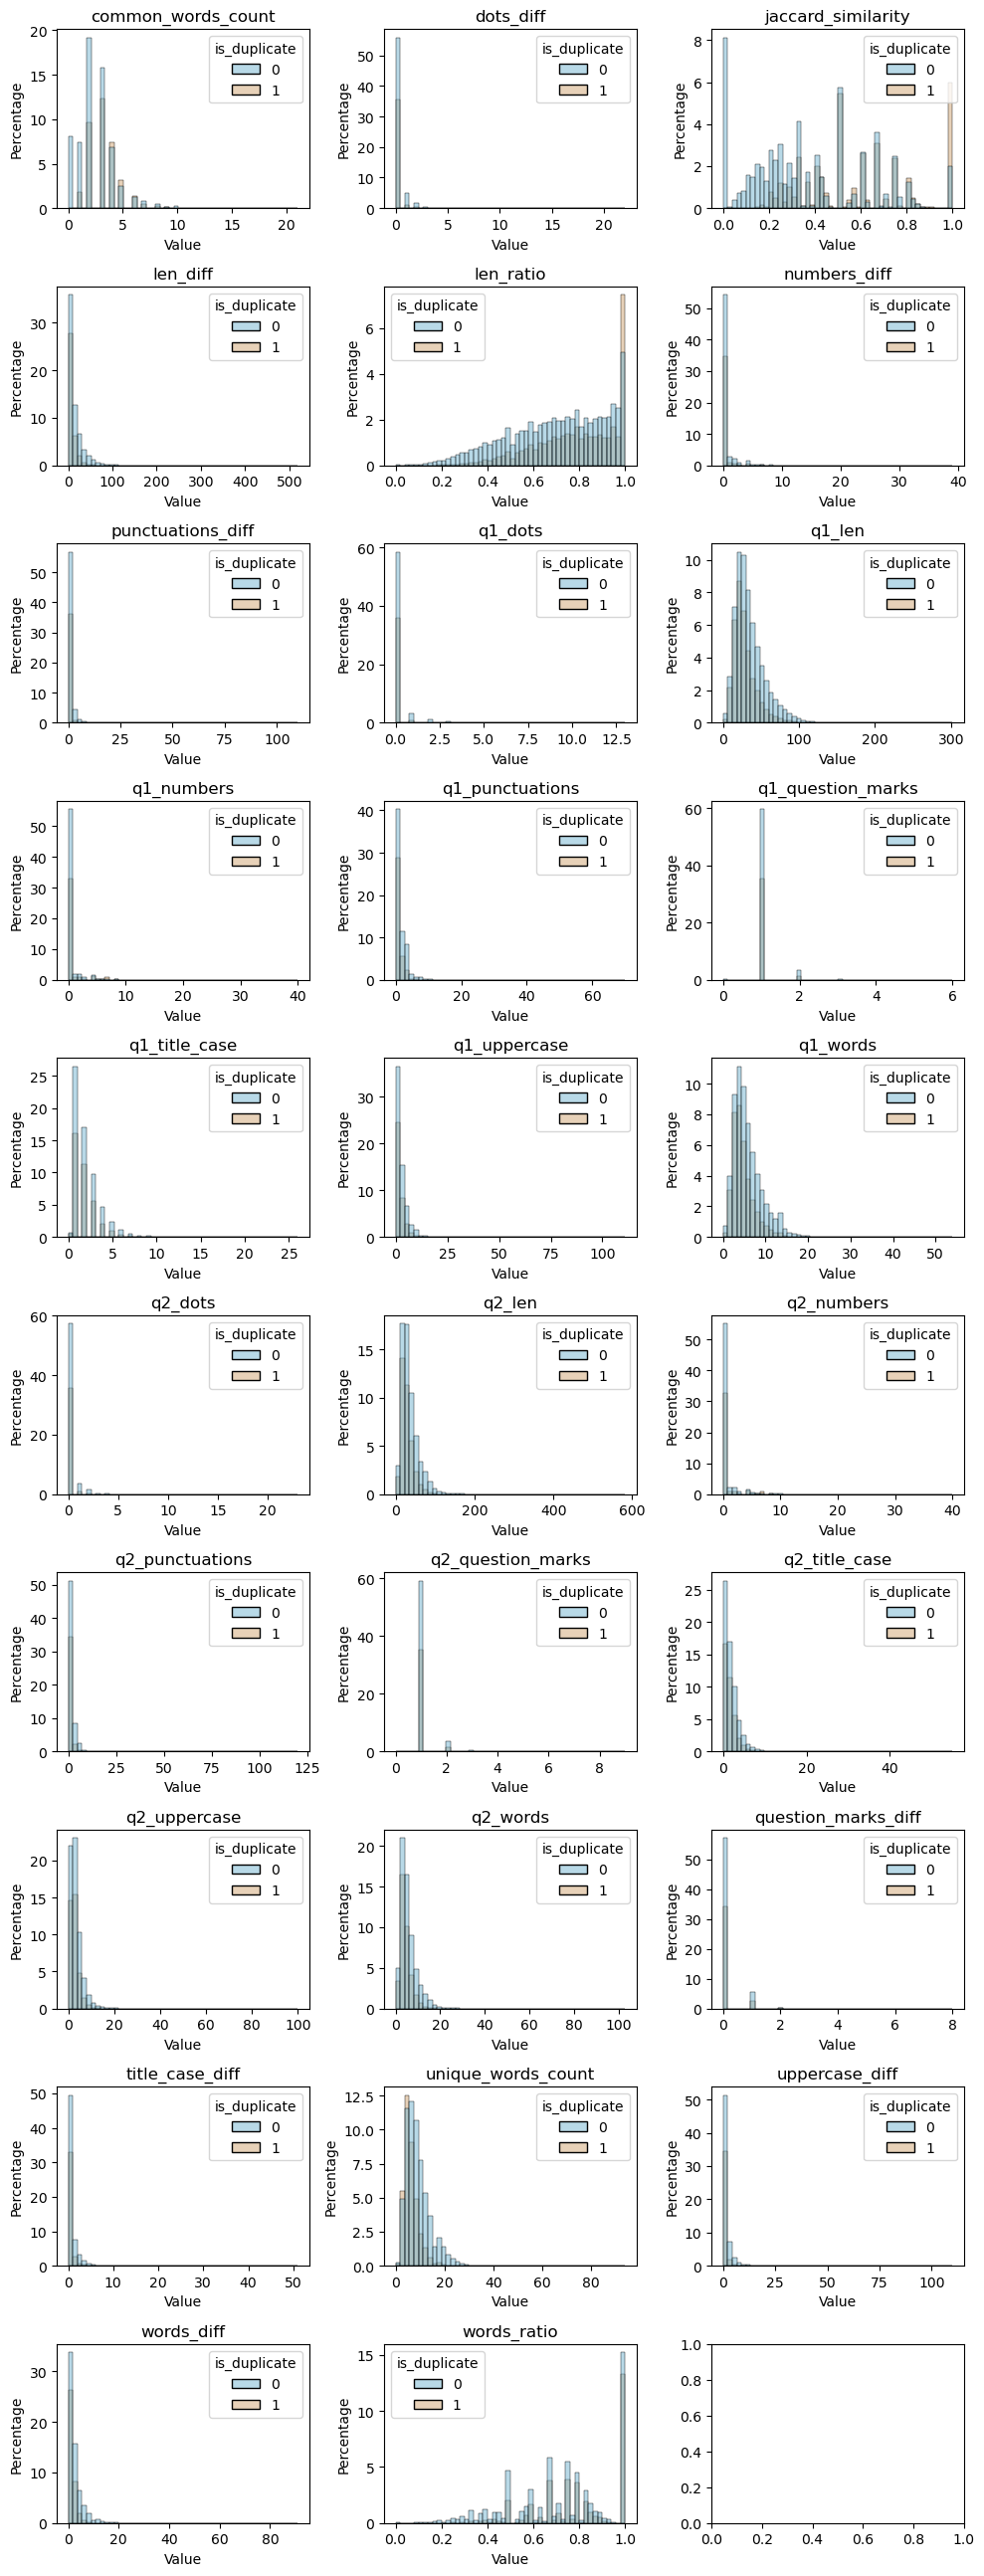

In [12]:
# Visualize feature distributions
fig, axes = plt.subplots(10, 3, figsize=(10, 26))
axes = axes.ravel()
palette = {1: '#D1A573', 0: '#73B5D1'}

for i, col in enumerate(feature_cols):
    sns.histplot(train_processed,
                 x=col, hue='is_duplicate',
                 bins=50, ax=axes[i],
                 palette=palette, stat='percent')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

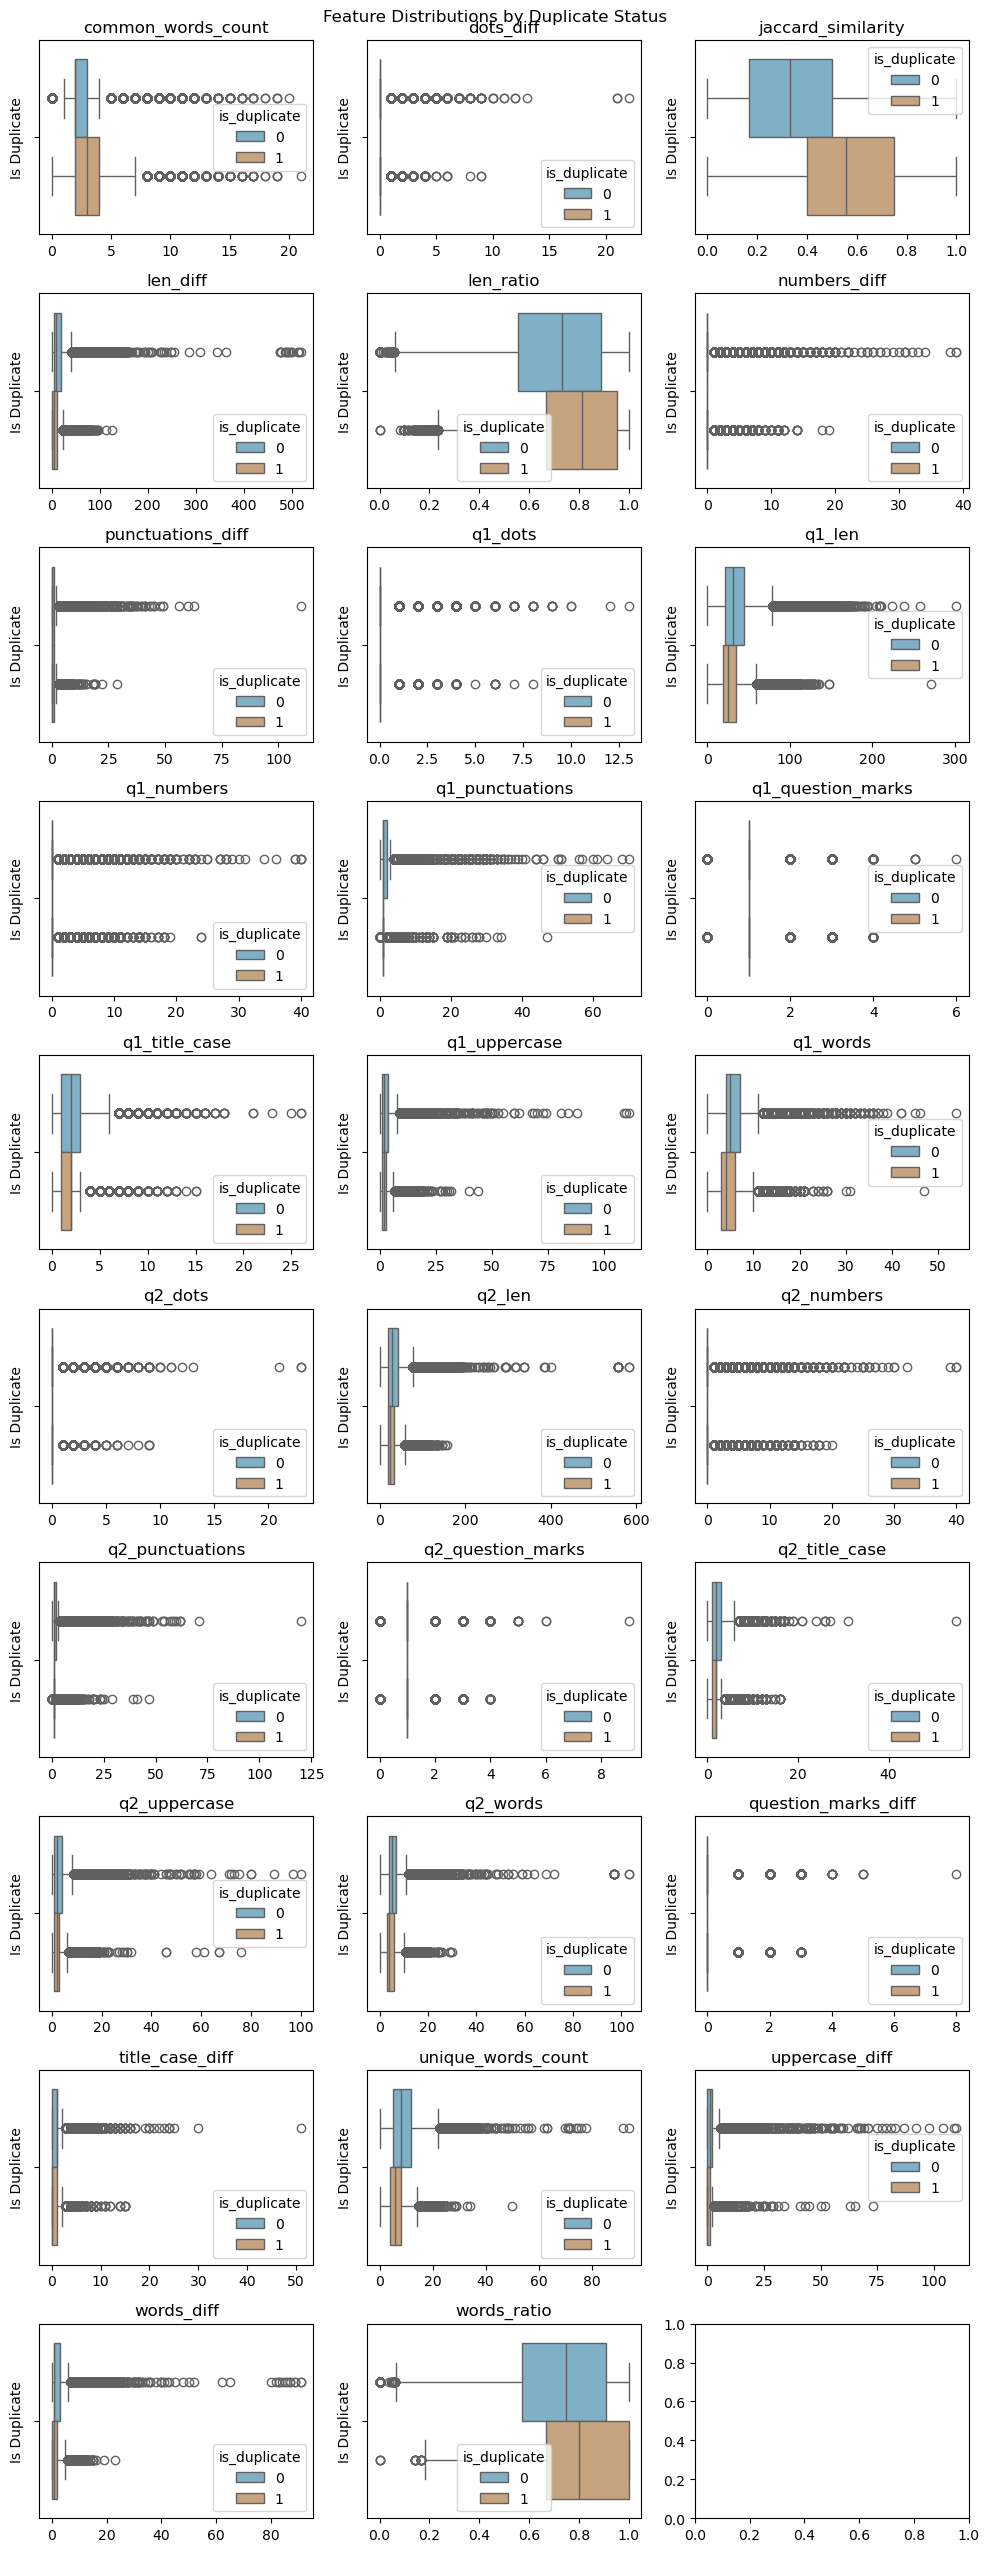

In [15]:
fig, axes = plt.subplots(10, 3, figsize=(10, 26))
axes = axes.ravel()

plt.suptitle('Feature Distributions by Duplicate Status\n')
for i, col in enumerate(feature_cols):
    sns.boxplot(train_processed,
                 x=col, hue='is_duplicate',
                 ax=axes[i],
                 palette=palette)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Is Duplicate')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

It looks like some features (`title_case`, `uppercase`, `len`, `punctuations`, `words`, `unique_words`, `jaccard_similarity`, `common_words_count`, `word_ratio`) have significantly different distributions across classes, so they may be useful for classification tasks.

## Correlation Analysis

=== Feature Correlation with Target ===
Top 5 positively correlated features:
jaccard_similarity    0.399386
common_words_count    0.229676
len_ratio             0.201016
words_ratio           0.188416
q1_numbers            0.017874
Name: is_duplicate, dtype: float64

Top 5 negatively correlated features:
q2_words             -0.172542
q1_len               -0.175721
words_diff           -0.213990
len_diff             -0.221424
unique_words_count   -0.294292
Name: is_duplicate, dtype: float64


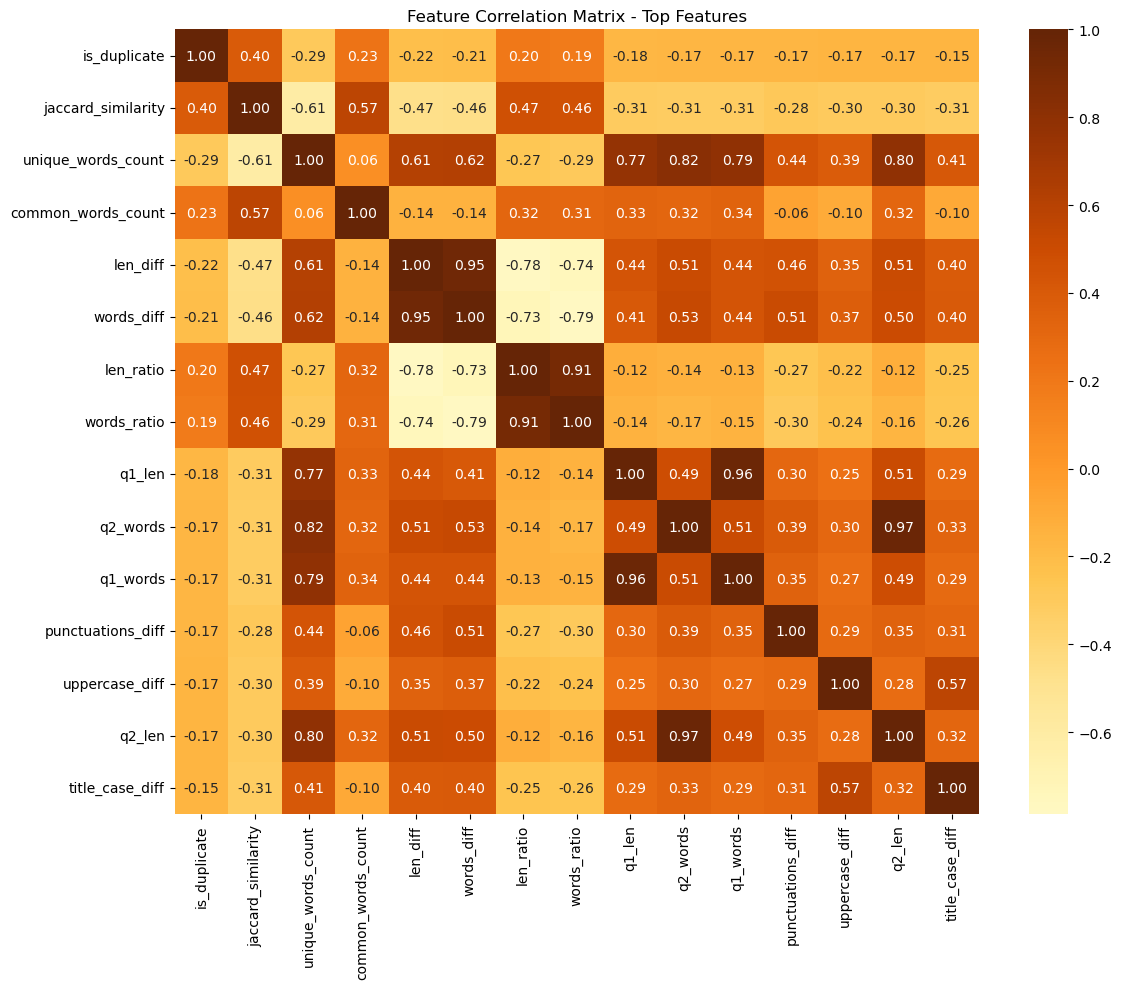

In [16]:
print("=== Feature Correlation with Target ===")

numeric_cols = train_processed[
    feature_cols  + ['is_duplicate']
].select_dtypes(include=[np.number]).columns
correlations = (train_processed[numeric_cols]
                .corr()['is_duplicate']
                .sort_values(ascending=False))

print("Top 5 positively correlated features:")
print(correlations[1:6])

print("\nTop 5 negatively correlated features:")
print(correlations.tail(5))

# Plot correlation heatmap for top features
top_features = correlations.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(train_processed[top_features].corr(),
            annot=True, cmap='YlOrBr', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix - Top Features')
plt.tight_layout()
plt.show()

`jaccard_similarity`, `common_words_count`, and `unique_words_count` show a strong correlation with the target variable, indicating they may be useful features for classification tasks.


## Process Test Data

In [17]:
test_df = pd.read_csv(os.path.join(PATH, 'raw/test.csv.zip'), index_col=0, compression='zip')

print(f"Test data shape: {test_df.shape}")

# Process test data if available
print("Processing test data...")

# Apply same preprocessing steps to test data
test_processed = test_df.copy()

# Handle missing values
test_processed = test_processed.dropna(subset=['question1', 'question2'])

# Text preprocessing
test_processed['question1_clean'] = (test_processed['question1']
                                     .progress_apply(preprocess_pipeline))
test_processed['question2_clean'] = (test_processed['question2']
                                     .progress_apply(preprocess_pipeline))

# Feature engineering
print("Creating features for test data...")
test_processed = calculate_text_features(test_processed)

print(f"Test data processed successfully! Shape: {test_processed.shape}")

Test data shape: (80858, 5)
Processing test data...


  0%|          | 0/80858 [00:00<?, ?it/s]

  0%|          | 0/80858 [00:00<?, ?it/s]

Creating features for test data...
Test data processed successfully! Shape: (80858, 36)


## Data Splitting


In [ ]:
train, val = train_test_split(
    train_processed,
    test_size=0.2,
    random_state=7,
    stratify=train_processed['is_duplicate']
)

print(f"\nData splits:")
print(f"Train: {train.shape[0]} samples ({train['is_duplicate'].mean():.2%} duplicates)")
print(f"Validation: {val.shape[0]} samples ({val['is_duplicate'].mean():.2%} duplicates)")
print(f"Test: {test_processed.shape[0]} samples ({test_processed['is_duplicate'].mean():.2%} duplicates)")


Data splits:
Train: 258743 samples (36.92% duplicates)
Validation: 64686 samples (36.92% duplicates)
Test: 80858 samples (36.92% duplicates)


## Save Processed Data

In [ ]:
# Save processed data
print("Saving processed data...")

train.to_csv(os.path.join(PATH, 'processed/train.csv.zip'),
             index=False,
             compression='zip')
val.to_csv(os.path.join(PATH, 'processed/val.csv.zip'),
           index=False,
           compression='zip')
test_processed.to_csv(os.path.join(PATH, 'processed/test.csv.zip'),
                      index=False,
                      compression='zip')

print(f"Processed data saved to: '../data/processed/'")

Saving processed data...
Processed data saved to: '../data/processed/'


The processed data is now ready for modeling in subsequent notebooks.

In [ ]:
text_features = train_processed.select_dtypes(include=[object]).columns.tolist()

feature_info = {
    'numerical_features': feature_cols,
    'text_features': text_features
}

joblib.dump(feature_info, os.path.join(PATH, 'processed/feature_info.joblib'))

['/content/drive/MyDrive/quora_duplicate_questions/data/processed/feature_info.joblib']